# **Анализ ошибок и успехов за период**

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
import os
import sys
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import Image
import shutil  # упаковка в архив
import warnings  # игнорирование предупреждения о формате при импорте из excel

warnings.simplefilter("ignore")


def anova(data):
    """функция выводит на печать результаты дисперсионного анализа набора данных"""
    # data.boxplot(figsize=(10, 6))
    # print("Нулевая гипотеза:", "=".join(data))
    # print("Альтернативная гипотеза:", f'!({"=".join(data)})')
    # общая средняя
    grand_mean = data.values.flatten().mean()
    # Общая сумма квадратов sst = ssb + ssw
    sst = sum((val - grand_mean) ** 2 for val in data.values.flatten())
    # отклонение групповых средний от общей средней
    ssb = sum(
        data[group].size * (group_mean - grand_mean) ** 2
        for group, group_mean in data.mean().items()
    )
    # отклонения значений внутри группы от средней группы
    ssw = sum(
        sum((x - group_mean) ** 2 for x in data[group])
        for group, group_mean in data.mean().items()
    )

    groups = data.shape[1]
    # Степени свободы
    dfb = groups - 1
    dfw = data.size - groups
    # межгрупповой средний квадрат
    mssb = ssb / dfb
    # внутригрупповой средний квадрат
    mssw = ssw / dfw

    f_value = mssb / mssw

    p = stats.f.sf(f_value, dfb, dfw)
    # print(f"внутригрупповая df: {dfb}, межгрупповая df: {dfw}")
    if p < 0.05:
        print("между наборами данных имеются статистически значимые отличия:")
        return 1
    else:
        print("между наборами данных не имеется статистически значимых отличий")
        return 0
    print(f"Полученное f-значение {f_value}")


def tukey(data):
    """функция возвращает результаты теста Тьюки в виде датафрейма
    исходные данные - df_dm и df_ndm, до преобразования в свобную таблицу"""
    tukey = pairwise_tukeyhsd(
        endog=data["value"], groups=data["real_region_name"], alpha=0.05
    )
    df_t = pd.DataFrame(
        data=tukey._results_table.data[1:], columns=tukey._results_table.data[0]
    )
    return df_t[df_t["reject"] == True]

## I. Формирование набора данных

In [4]:
%%time
# загрузка данных ошибок, успехов и витрин

# пути к файлам
dir_path = os.getcwd().replace("\\", "/")
error_path = '/'.join(dir_path.split('/')[:3]) + '/error'
error_file_list = os.listdir(error_path)
successful_parh = '/'.join(dir_path.split('/')[:3]) + '/succsessful'
successful_file_list = os.listdir(successful_parh)
showcase_parh = '/'.join(dir_path.split('/')[:3]) + '/showcase/'
showcase_file_list = os.listdir(showcase_parh)
result_path = '/'.join(dir_path.split('/')[:3]) + '/result/'
pos_path = '/'.join(dir_path.split('/')[:3]) + '/pos/'
print('созданы пути к файлам')
# список типов записи
type_list = ['3']


созданы пути к файлам
CPU times: total: 0 ns
Wall time: 0 ns


In [20]:
%%time
# определение типа файлов в целевой папке по расширению первого файла в директории данных ошибок, другие расширения будет нельзя
try:
    extension = error_file_list[0].split(".")[-1]
except Exception:
    print(
        "проверьте содержимое целевой директории фалов ошибок записи - в ней что-то не так"
    )
    sys.exit()
print(f"ожидаемое расширение для ВСЕХ файлов в целевой директории: {extension}")
# создание фреймов успехов и ошибок
df_error = pd.DataFrame()
for error_file in error_file_list:
    concat_flag = 0
    error_file_path = error_path + "/" + error_file
    if extension == "xlsx" and error_file.split('.')[-1] == 'xlsx':
        try:
            df_error_day = pd.read_excel(
                error_file_path, sheet_name="1", index_col=None, dtype="str"
            )
            print(f"\t- успешно прочитан файл {error_file_path}")
            concat_flag = 1
        except Exception:
            print(f"\tошибка обработки файла {error_file}, файл пропущен")
    elif extension == "csv" and error_file.split('.')[-1] == 'csv':
        try:
            df_error_day = df_ass = pd.read_csv(
                error_file_path, sep=";", encoding="utf-8-sig", dtype="str"
            )
            print(f"\t- успешно прочитан файл {error_file_path}")
            concat_flag = 1
        except Exception:
            print(f"\tошибка обработки файла {error_file}, файл пропущен")
    else:
        print(f"\tфайл {error_file} имеет неверный тип, файл пропущен")
    if concat_flag == 1:
        df_error = pd.concat([df_error, df_error_day])
        print(f'\tданные из {error_file} присоединены к набору')
    else:
        print(f'\tданные из {error_file} не присоединены к набору')
df_error = df_error.reset_index(drop=True).rename(
    columns={
        "Название субъекта РФ": "region_name",
        "Тип записи": "appointment_type",
        "Post_name": "post_name",
    }
)
df_error["create_ts"] = pd.to_datetime(df_error["create_ts"], format="mixed")
# вставка столбца data в таблицу df_error
df_error.insert(
    0,
    "date",
    df_error["create_ts"].apply(
        lambda x: pd.to_datetime(str(x)[:10], format="%Y-%m-%d")
    ),
)
df_error["region_name"] = df_error["region_name"].fillna('Кемская волость')
df_error = df_error[df_error["appointment_type"].isin(type_list)]
print("данные ошибок записи сформированы")

df_succsessful = pd.DataFrame()
for succsessful_file in successful_file_list:
    concat_flag = 0
    succsessful_file_path = successful_parh + "/" + succsessful_file
    if extension == "xlsx" and succsessful_file.split('.')[-1] == 'xlsx':
        try:
            df_succsessful_day = pd.read_excel(
                succsessful_file_path, sheet_name="1", index_col=None, dtype="str"
            )
            print(f"\t- успешно прочитан файл {succsessful_file_path}")
            concat_flag = 1
        except Exception:
            print(f"\tошибка обработки файла {succsessful_file}, файл пропущен")
    elif extension == "csv" and succsessful_file.split('.')[-1] == 'csv':
        try:
            df_succsessful_day = df_ass = pd.read_csv(
                succsessful_file_path, sep=";", encoding="utf-8-sig", dtype="str"
            )
            print(f"\t- успешно прочитан файл {succsessful_file_path}")
            concat_flag = 1
        except Exception:
            print(f"\tошибка обработки файла {succsessful_file}, файл пропущен")
    else:
        print(f"\tфайл {succsessful_file} имеет неверный тип, файл пропущен")
    if concat_flag == 1:
        df_succsessful = pd.concat([df_succsessful, df_succsessful_day])
        print(f'\tданные из {succsessful_file} присоединены к набору')
    else:
        print(f'\tданные из {succsessful_file} не присоединены к набору')
df_succsessful = df_succsessful.reset_index(drop=True).rename(
    columns={
        "Дата": "date",
        "Название субъекта РФ": "region_name",
        "Тип записи": "appointment_type",
    }
)
df_succsessful["date"] = df_succsessful["create_ts"].apply(
    lambda x: pd.to_datetime(str(x)[:10], format="%Y-%m-%d")
)
df_succsessful["slot_ts"] = pd.to_datetime(df_succsessful["slot_ts"], format="mixed")
df_succsessful["create_ts"] = pd.to_datetime(
    df_succsessful["create_ts"], format="mixed"
)
df_succsessful["region_name"] = df_succsessful["region_name"].fillna('Кемская волость')
df_succsessful = df_succsessful[df_succsessful["appointment_type"].isin(type_list)]
print("данные успешных сессий сформированы")

# создание фрейма данных витрин
df_showcase = pd.read_excel(
    showcase_parh + showcase_file_list[-1],
    sheet_name="Сессии по датам",
    engine='openpyxl',
    index_col=None,
    dtype="str",
)
df_showcase["Дата"] = pd.to_datetime(df_showcase["Дата"], format="mixed")
df_showcase = df_showcase.rename(
    columns={
        "Код региона": "region_code",
        "Регион": "region_name",
        "Дата": "date",
        "Шаг": "step",
        "Всего": "total",
        "Успешно": "succsessful",
        "Ошибки ЕПГУ": "epgu_error",
        "Тех ошибки": "tech_error",
        "Орг ошибки": "org_error",
        "ПОДД": "podd",
        "Брошенные": "draft",
        "Бизнес-правила": "b-rules"
    }
)
df_showcase[df_showcase.columns[4:]] = df_showcase[df_showcase.columns[4:]].apply(
    pd.to_numeric, errors="ignore"
)
df_showcase["region_name"] = df_showcase["region_name"].fillna('Кемская волость')
print("данные витрин ЕПГУ загружены")

ожидаемое расширение для ВСЕХ файлов в целевой директории: csv
	- успешно прочитан файл c:/work/comparison_error_successful/error/01.01.2024.csv
	данные из 01.01.2024.csv присоединены к набору
	- успешно прочитан файл c:/work/comparison_error_successful/error/02.01.2024.csv
	данные из 02.01.2024.csv присоединены к набору
	- успешно прочитан файл c:/work/comparison_error_successful/error/03.01.2024.csv
	данные из 03.01.2024.csv присоединены к набору
	- успешно прочитан файл c:/work/comparison_error_successful/error/04.01.2024.csv
	данные из 04.01.2024.csv присоединены к набору
	- успешно прочитан файл c:/work/comparison_error_successful/error/05.01.2024.csv
	данные из 05.01.2024.csv присоединены к набору
	- успешно прочитан файл c:/work/comparison_error_successful/error/06.01.2024.csv
	данные из 06.01.2024.csv присоединены к набору
	- успешно прочитан файл c:/work/comparison_error_successful/error/07.01.2024.csv
	данные из 07.01.2024.csv присоединены к набору
	- успешно прочитан файл c:

### 1. Однообразный диапазон дат
##### *В отчёт попадут только данные из этого диапазона*

In [21]:
date_begin = max(df_error.date.min(), df_succsessful.date.min(), df_showcase.date.min())
date_end = min(df_error.date.max(), df_succsessful.date.max(), df_showcase.date.max())


df_error = df_error[
    (df_error.date >= date_begin) & (df_error.date <= date_end)
].reset_index(drop=True)


df_succsessful = df_succsessful[
    (df_succsessful.date >= date_begin) & (df_succsessful.date <= date_end)
].reset_index(drop=True)


df_showcase = df_showcase[
    (df_showcase.date >= date_begin) & (df_showcase.date <= date_end)
].reset_index(drop=True)


print(f"В отчёте даты с {date_begin.date()} по {date_end.date()}")

В отчёте даты с 2024-01-01 по 2024-01-21


### 2. Однообразный перечень регионов
##### *К наборам данных будет добавлены единые названия регионов из таблицы соответствия*
###### _А ты не забыл актуализировать `таблицу соответствия названий регионов` в директории исполняемого файла скрипта?_

In [22]:
# загрузка справочника, который хранится в директории скрипта
df_reg_ref = pd.read_csv(dir_path + "/" + "reg_ref.csv", sep=";")

# присоединение единого названия региона
df_error = df_error.merge(
    df_reg_ref, left_on="region_name", right_on="region_name_file", how="left"
)
df_error = df_error.drop("region_name_file", axis=1)

df_succsessful = df_succsessful.merge(
    df_reg_ref, left_on="region_name", right_on="region_name_file", how="left"
)
df_succsessful = df_succsessful.drop("region_name_file", axis=1)

df_showcase = df_showcase.merge(
    df_reg_ref, left_on="region_name", right_on="region_name_file", how="left"
)
df_showcase = df_showcase.drop("region_name_file", axis=1)

### 3. Проверки на дубли в session_id

In [23]:
dup_succsessful = df_succsessful.loc[
    df_succsessful.duplicated(subset=["date", "session_id"], keep=False)
].sort_values(by=["date", "session_id"])
if dup_succsessful.shape[0] / 2 == len(dup_succsessful["session_id"].unique()):
    print(
        f"в успехах {len(dup_succsessful['session_id'].unique())} повторяющихся session_id внутри одной даты"
    )
elif dup_succsessful.shape[0] / 2 != len(dup_succsessful["session_id"].unique()):
    print(f"в ошибках какая-то фигня с повторами в session_id в успехах")
else:
    print("рандомный трабл")

dup_error = df_error.loc[
    df_error.duplicated(subset=["date", "session_id"], keep=False)
].sort_values(by=["date", "session_id"])
if dup_error.shape[0] / 2 == len(dup_error["session_id"].unique()):
    print(
        f"в ошибках {len(dup_error['session_id'].unique())} повторяющихся session_id внутри одной даты"
    )
elif dup_error.shape[0] / 2 != len(dup_error["session_id"].unique()):
    print(f"в ошибках какая-то фигня с повторами в session_id")
else:
    print("рандомный трабл")

в успехах 0 повторяющихся session_id внутри одной даты
в ошибках 16 повторяющихся session_id внутри одной даты


### 4. Статистика ошибок записи через ЕПГУ

<div class="alert alert-info">
а) cчитаем количество строк в разрезе final_state - <b> верный подход </b>
</div>

In [24]:
# группировка по дате, региогну и событию
df_error_group = (
    df_error.groupby(["date", "real_region_name", "final_state"])["session_id"]
    .count()
    .reset_index()
    .rename(columns={"final_state": "event", "session_id": "value"})
)
# перечень всех событий
df_error_event = (
    pd.DataFrame(df_error_group.event)
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={"event": "event"})
)
# перечни регионов и дат
date_list = df_error.date.unique().tolist()
region_list = df_error.real_region_name.unique().tolist()
# формирование набора статистических данных для ошибок записи
df_error_statistic = pd.DataFrame()
for date in date_list:
    for region in region_list:
        df_loc_day = df_error_group[
            (df_error_group.real_region_name == region) & (df_error_group.date == date)
        ]
        df_loc_day = df_loc_day.merge(df_error_event, on="event", how="right")
        df_loc_day["date"] = df_loc_day["date"].fillna(date)
        df_loc_day["real_region_name"] = df_loc_day["real_region_name"].fillna(region)
        df_loc_day["value"] = df_loc_day["value"].fillna(0)
        df_error_statistic = pd.concat([df_error_statistic, df_loc_day])

<div class="alert alert-block alert-warning">
б) cчитаем количество уникальных session_id в разрезе final_state - <b>неверный подход</b>
</div>

In [7]:
# группировка по дате, региогну и событию
df_error_group = (
    df_error.groupby(["date", "real_region_name", "final_state"])["session_id"]
    .nunique()
    .reset_index()
    .rename(columns={"final_state": "event", "session_id": "value"})
)
# перечень всех событий
df_error_event = (
    pd.DataFrame(df_error_group.event)
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={"event": "event"})
)
# перечни регионов и дат
date_list = df_error.date.unique().tolist()
region_list = df_error.real_region_name.unique().tolist()
# формирование набора статистических данных для ошибок записи
df_error_statistic = pd.DataFrame()
for date in date_list:
    for region in region_list:
        df_loc_day = df_error_group[
            (df_error_group.real_region_name == region) & (df_error_group.date == date)
        ]
        df_loc_day = df_loc_day.merge(df_error_event, on="event", how="right")
        df_loc_day["date"] = df_loc_day["date"].fillna(date)
        df_loc_day["real_region_name"] = df_loc_day["real_region_name"].fillna(region)
        df_loc_day["value"] = df_loc_day["value"].fillna(0)
        df_error_statistic = pd.concat([df_error_statistic, df_loc_day])

### 5. Статистика успешных записей через ЕПГУ

<div class="alert alert-info">
а) cчитаем количество строк  - <b> верный подход </b>
</div>

In [25]:
df_succsessful_statistic = (
    df_succsessful.groupby(["date", "real_region_name"])["session_id"]
    .count()
    .reset_index()
    .rename(columns={"session_id": "value"})
)
df_succsessful_statistic.insert(2, "event", "Успешная запись (ЕПГУ)")

<div class="alert alert-block alert-warning">
б) cчитаем количество уникальных session_id - <b>неверный подход</b>
</div>

In [36]:
df_succsessful_statistic = (
    df_succsessful.groupby(["date", "real_region_name"])["session_id"]
    .nunique()
    .reset_index()
    .rename(columns={"session_id": "value"})
)
df_succsessful_statistic.insert(2, "event", "Успешная запись (ЕПГУ)")

### 6. Статистика использования витрин

In [26]:
# успешные записи через витрины
df_showcase_succsessuil = df_showcase[
    df_showcase.step == "Шаг 4. Запись. Уникальные сессии"
][["date", "real_region_name", "succsessful"]].rename(columns={"succsessful": "value"})
df_showcase_succsessuil.insert(2, "event", "Успешные записи (витрины)")
# количество ошибок через витрины
df_showcase_error = (
    df_showcase.groupby(["date", "real_region_name"])[
        ["epgu_error", "tech_error", "org_error", "podd", "draft", "b-rules"]
    ]
    .sum()
    .reset_index()
)
# ошибки записи через витрины
df_showcase_error.rename(
    columns={
        "epgu_error": "Ошибки ЕПГУ (витрины)",
        "tech_error": "Технические ошибки (витрины)",
        "org_error": "Организационные ошибки (витрины)",
        "podd": "ПОДД (витрины)",
        "draft": "Брошеные (витрины)",
        "b-rules": "Бизнес-правила (витрины)",
    },
    inplace=True,
)
# преобразование в "длинную" таблицу
df_showcase_error = pd.melt(
    df_showcase_error,
    id_vars=["date", "real_region_name"],
    value_vars=[
        "Ошибки ЕПГУ (витрины)",
        "Технические ошибки (витрины)",
        "Организационные ошибки (витрины)",
        "ПОДД (витрины)",
        "Брошеные (витрины)",
        "Бизнес-правила (витрины)",
    ],
)
df_showcase_error.rename(columns={"variable": "event"}, inplace=True)
df_showcase_statistic = (
    pd.concat([df_showcase_succsessuil, df_showcase_error])
    .sort_values(by=["date", "real_region_name", "event"])
    .reset_index(drop=True)
)

### **7. Профиль регионов**

In [27]:
# объединение статистики успехов, ошибок и витрин
df_statistic = pd.concat([df_error_statistic, df_succsessful_statistic]).sort_values(
    by=["date", "real_region_name"]
)

df_statistic = (
    pd.concat([df_statistic, df_showcase_statistic])
    .sort_values(by=["date", "real_region_name"])
    .reset_index(drop=True)
)

# удаление строк спустыми регионами если для них все предикторы равны 0
if df_statistic[df_statistic["real_region_name"].isna()]["value"].sum() < 0.1:
    df_statistic.dropna(subset=["real_region_name"], inplace=True)
# предикторы профиля
df_full_event = (
    pd.DataFrame(df_statistic["event"]).drop_duplicates().reset_index(drop=True)
)
print(f"Всего в профиле региона {df_full_event.shape[0]} предиктора(ов)")

# создание профиля региона
df_stat_full = pd.DataFrame()
for date in df_statistic["date"].unique().tolist():
    for region in df_statistic["real_region_name"].unique().tolist():
        df_stat_tmp = df_statistic[
            (df_statistic["date"] == date)
            & (df_statistic["real_region_name"] == region)
        ]
        df_stat_tmp = df_stat_tmp.merge(
            df_full_event, left_on="event", right_on="event", how="right"
        )
        df_stat_tmp["date"].fillna(date, inplace=True)
        df_stat_tmp["real_region_name"].fillna(region, inplace=True)
        df_stat_tmp["value"].fillna(0, inplace=True)
        df_stat_full = pd.concat([df_stat_full, df_stat_tmp])
        # break
df_stat_full.reset_index(drop=True, inplace=True)
df_stat_full["value"] = df_stat_full["value"].astype(int)

Всего в профиле региона 24 предиктора(ов)


In [28]:
# df_stat_full[
#     (df_stat_full.real_region_name == "Самарская область")
#     & (df_stat_full.date == "2024-01-10")
# ]
# df_stat_full.head(df_full_event.shape[0])
df_stat_full

,date,real_region_name,event,value
0,2024-01-01,Алтайский край,Внутренняя ошибка РМИС при создании записи,1
1,2024-01-01,Алтайский край,Значение не найдено,42
2,2024-01-01,Алтайский край,Ошибка валидации данных пациента,9
3,2024-01-01,Алтайский край,Ошибка во входных параметрах при записи на прием,113
4,2024-01-01,Алтайский край,Ошибка отсутсвует,3745
...,...,...,...,...
44347,2024-01-21,г. Севастополь,Организационные ошибки (витрины),0
44348,2024-01-21,г. Севастополь,Ошибки ЕПГУ (витрины),0
44349,2024-01-21,г. Севастополь,ПОДД (витрины),0
44350,2024-01-21,г. Севастополь,Технические ошибки (витрины),0


***

## II. Статистический анализ

### а) линейная корреляция (если просто посмотреть)

In [212]:
# дата анализа
# analist_date = "2024-01-12"
analist_date = date_end
df_analist = df_stat_full[df_stat_full["date"] == analist_date]

df_predictors_list = [
    "Бизнес-правила (витрины)",
    "Брошеные (витрины)",
    "Организационные ошибки (витрины)",
    "Ошибки ЕПГУ (витрины)",
    "ПОДД (витрины)",
    "Технические ошибки (витрины)",
]

# "витринный" и "невиринный" наборы данных на дату анализа
df_dm = pd.DataFrame()
df_ndm = pd.DataFrame()
for region_name in df_analist["real_region_name"].unique().tolist():
    df_tmp = df_analist[df_analist["real_region_name"] == region_name]
    if df_tmp[df_tmp["event"].isin(df_predictors_list)]["value"].sum() != 0:
        df_dm = pd.concat([df_dm, df_tmp])
    else:
        df_ndm = pd.concat([df_ndm, df_tmp])
df_dm = df_dm[["real_region_name", "event", "value"]]
df_ndm = df_ndm[["real_region_name", "event", "value"]]

# создание сводных таблиц
df_ndm_pt = (
    df_ndm.pivot_table(
        index="event", columns="real_region_name", values="value", aggfunc="sum"
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

df_dm_pt = (
    df_dm.pivot_table(
        index="event", columns="real_region_name", values="value", aggfunc="sum"
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

##### **Витринные регионы**

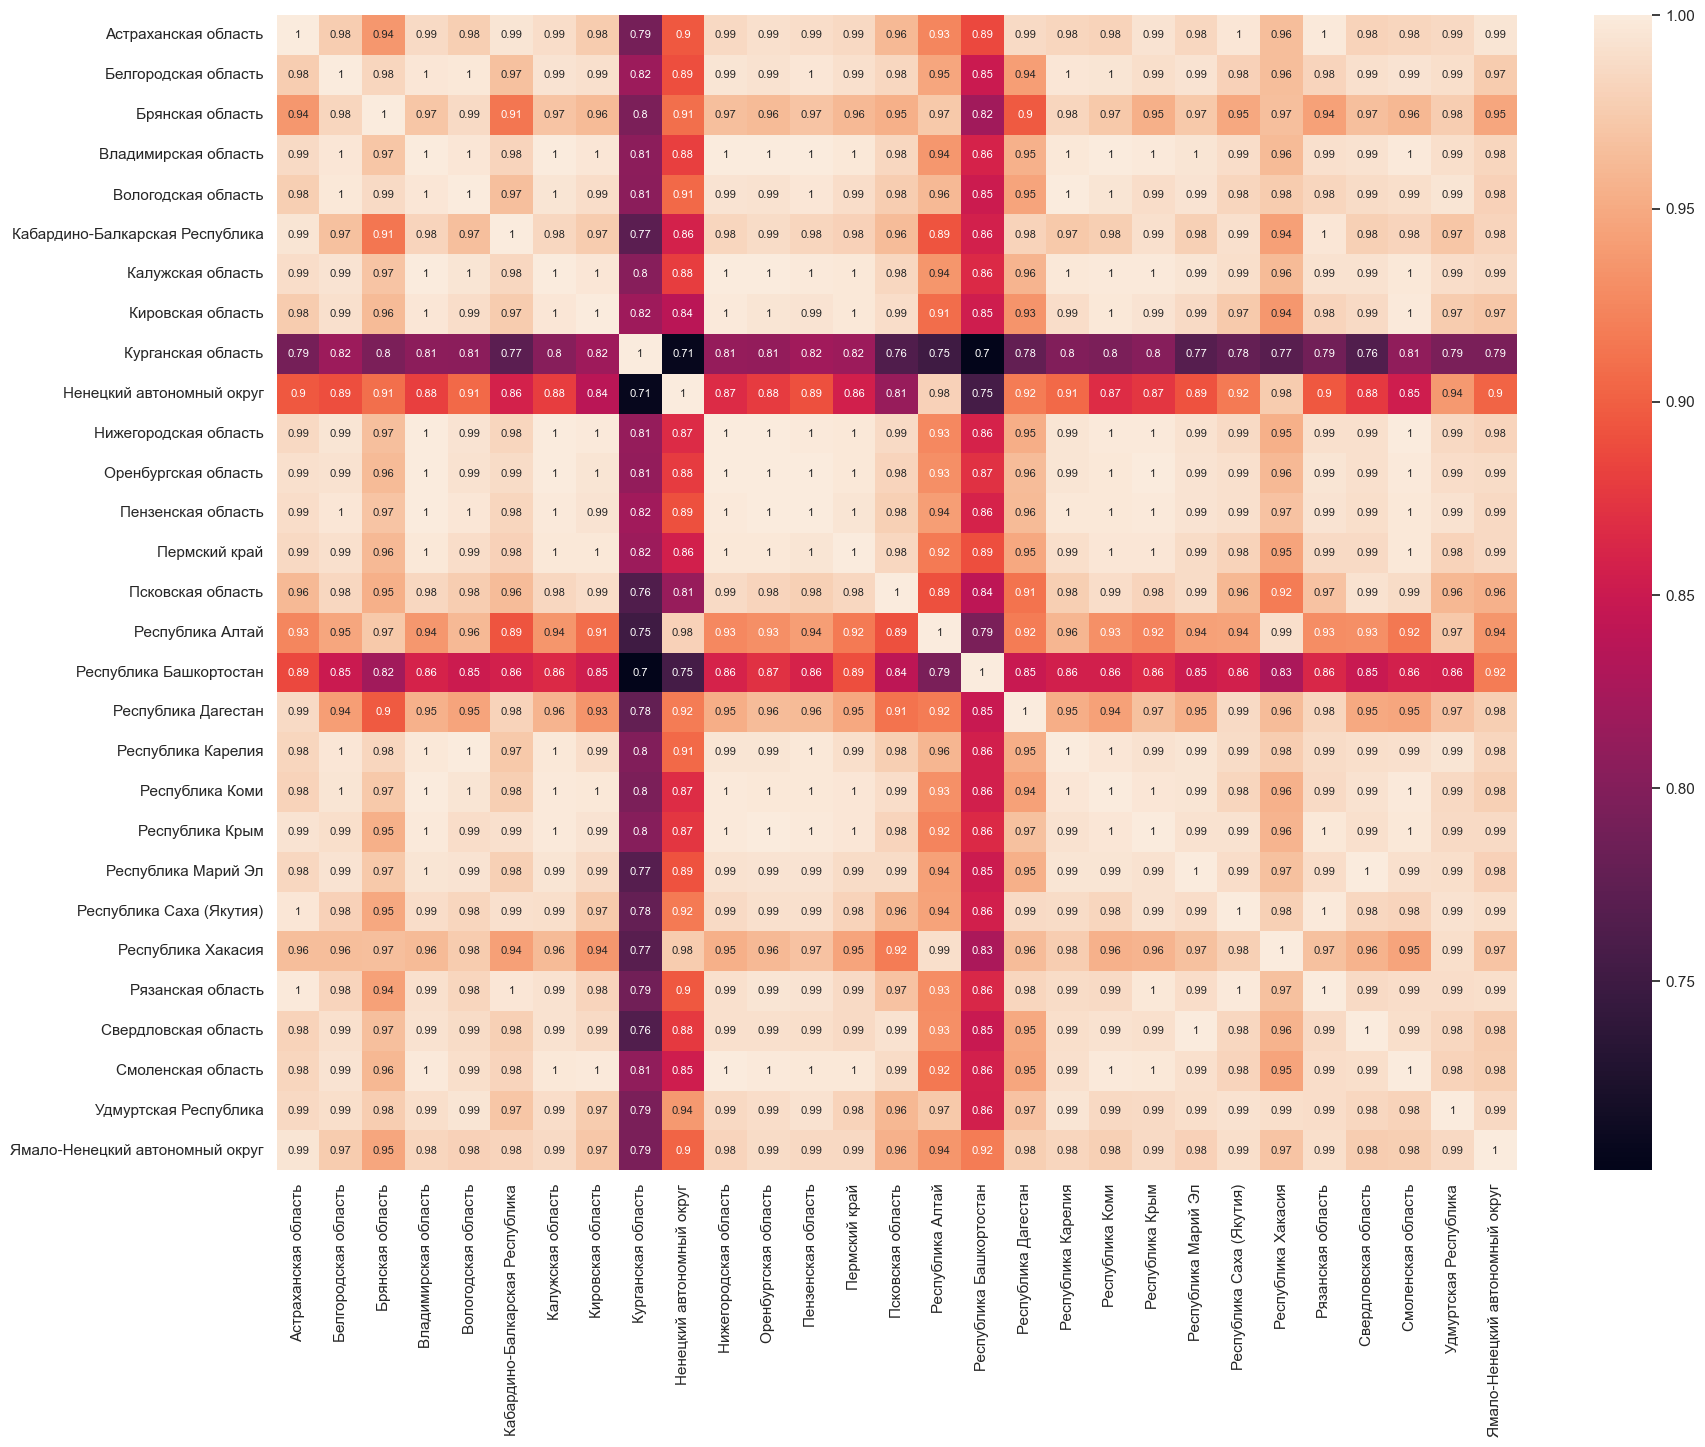

In [32]:
cols = df_dm_pt.columns[1:]
sns.set(rc={"figure.figsize": (20, 15), "font.size": 8})
hm = sns.heatmap(df_dm_pt[cols].corr(), cbar=True, annot=True)

##### **Безвитринные регионы**

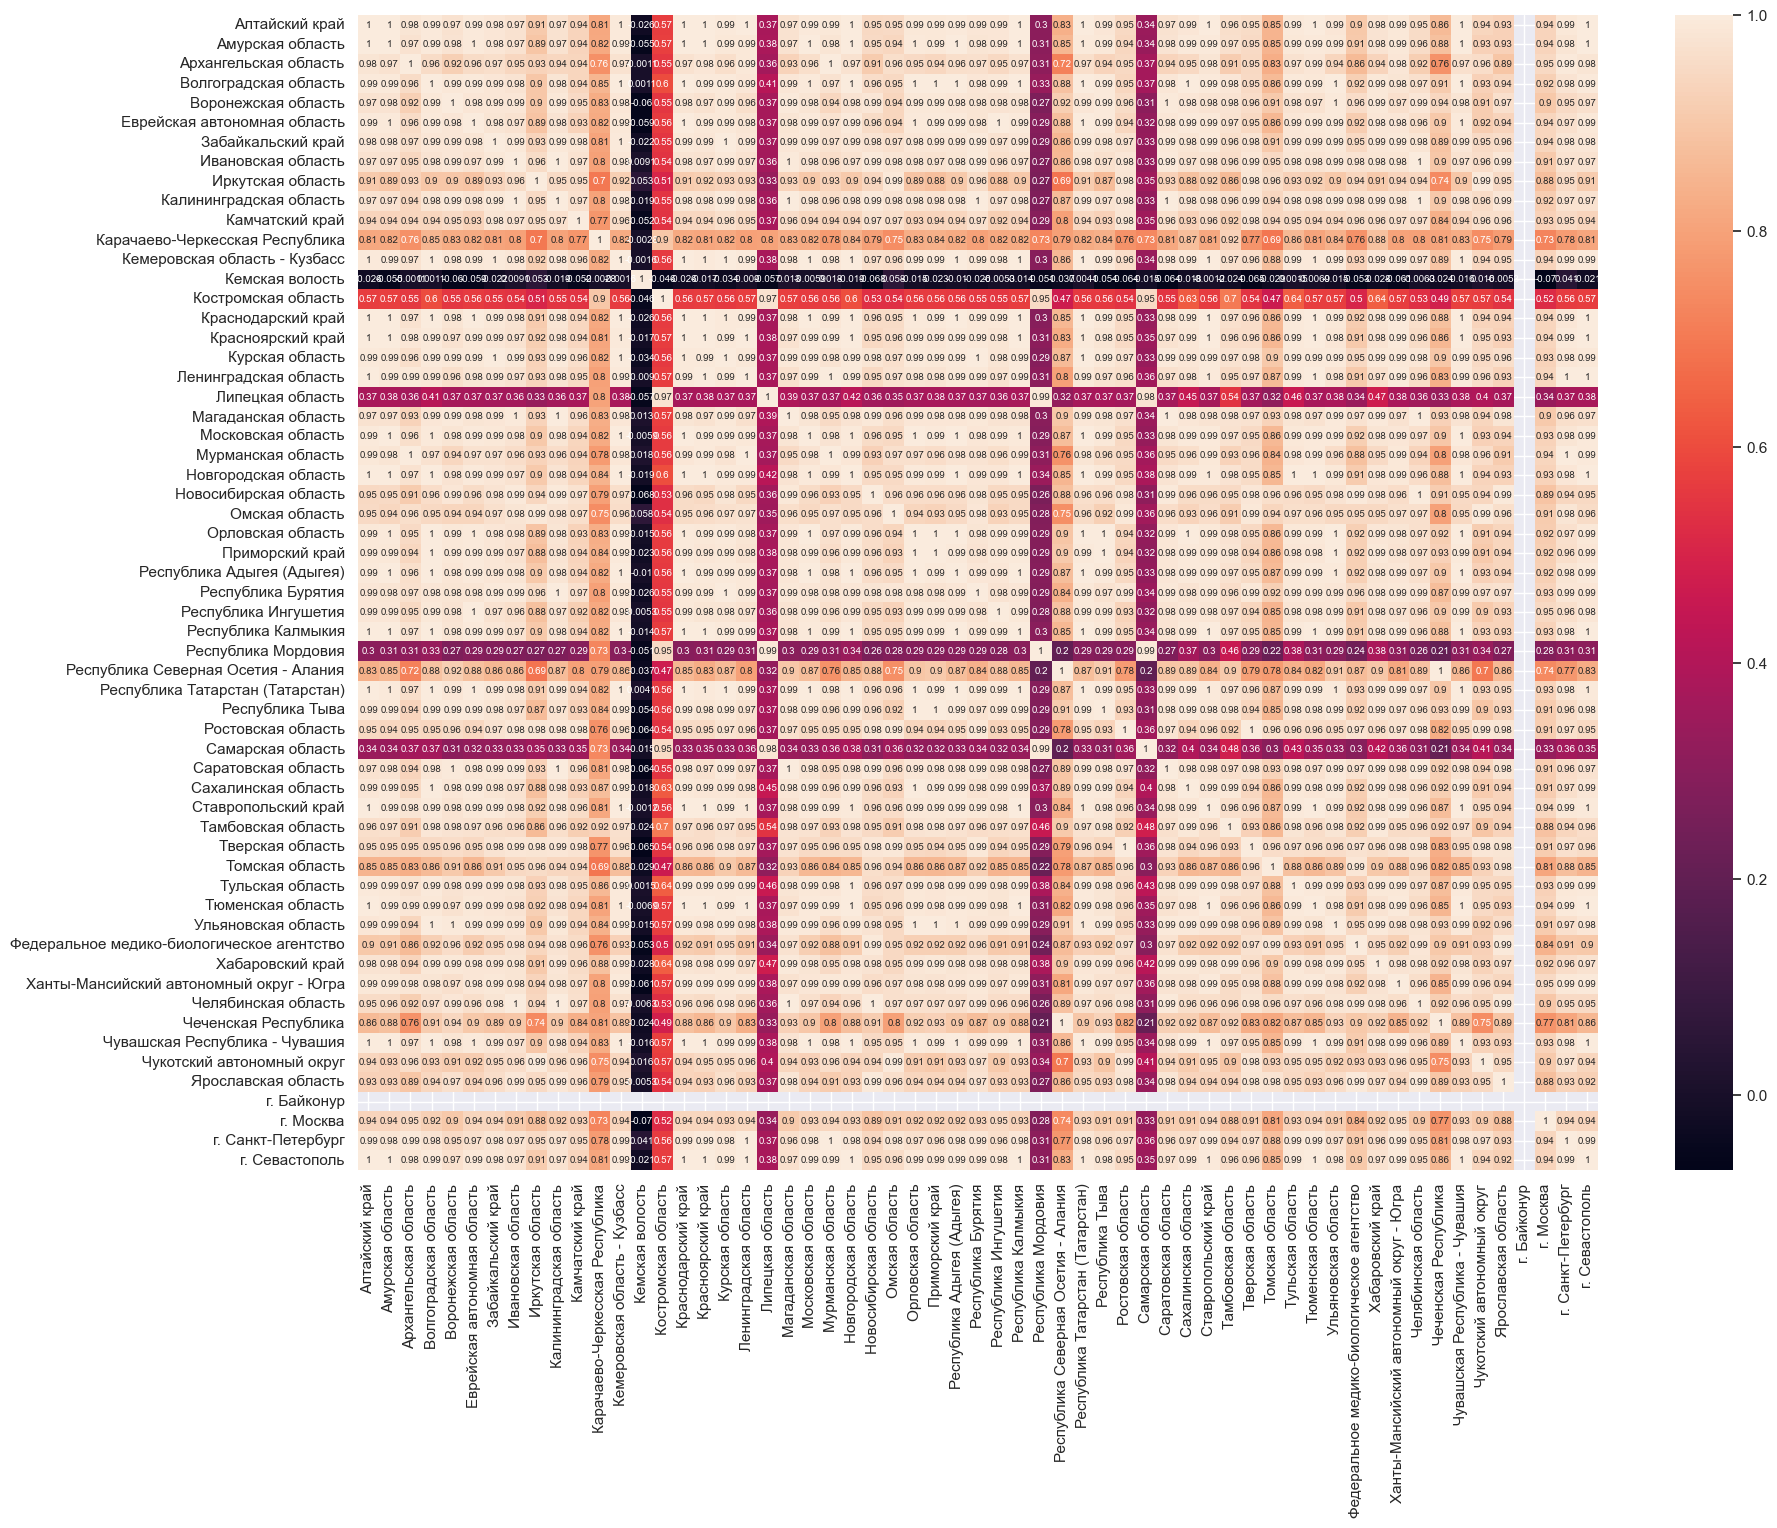

In [33]:
cols = df_ndm_pt.columns[1:]
sns.set(rc={"figure.figsize": (20, 15), "font.size":7})
hm = sns.heatmap(df_ndm_pt[cols].corr(), cbar=True, annot=True)

### б) дисперсионный анализ

##### **Витринные регионы**

In [218]:
try:
    print(f"Дата анализа: {analist_date.date()}")
except Exception:
    print(f"Дата анализа: {analist_date}")
df_dm_anova = df_dm_pt[df_dm_pt.columns[1:]]
if anova(df_dm_anova) == 1:
    tukey_dm = pairwise_tukeyhsd(
        endog=df_dm["value"], groups=df_dm["real_region_name"], alpha=0.05
    )
    df_t_dm = pd.DataFrame(
        data=tukey_dm._results_table.data[1:], columns=tukey_dm._results_table.data[0]
    )
    df_t_dm = df_t_dm[df_t_dm["reject"] == True]
    print(df_t_dm.to_string(index=False))

Дата анализа: 2024-01-21
между наборами данных не имеется статистически значимых отличий


##### **Безвитринные регионы**

In [219]:
try:
    print(f"Дата анализа: {analist_date.date()}")
except Exception:
    print(f"Дата анализа: {analist_date}")
df_ndm_anova = df_ndm_pt[df_ndm_pt.columns[1:]]
if anova(df_ndm_anova) == 1:
    tukey_ndm = pairwise_tukeyhsd(
        endog=df_ndm["value"], groups=df_ndm["real_region_name"], alpha=0.05
    )
    df_t_ndm = pd.DataFrame(
        data=tukey_ndm._results_table.data[1:], columns=tukey_ndm._results_table.data[0]
    )
    df_t_ndm = df_t_ndm[df_t_ndm["reject"] == True]
    print(df_t_ndm.to_string(index=False))

Дата анализа: 2024-01-21
между наборами данных не имеется статистически значимых отличий


##### **Без разделения на витринные и безвитринные регионы**

In [220]:
df_date = df_stat_full[df_stat_full["date"] == analist_date]
# создание сводных таблиц
df_pt = (
    df_date.pivot_table(
        index="event", columns="real_region_name", values="value", aggfunc="sum"
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
try:
    print(f"Дата анализа: {analist_date.date()}")
except Exception:
    print(f"Дата анализа: {analist_date}")
df_full_anova = df_pt[df_pt.columns[1:]]
if anova(df_full_anova) == 1:
    tukey_full = pairwise_tukeyhsd(
        endog=df_date["value"], groups=df_date["real_region_name"], alpha=0.05
    )
    df_t_full = pd.DataFrame(
        data=tukey_full._results_table.data[1:],
        columns=tukey_full._results_table.data[0],
    )
    df_t_full = df_t_full[df_t_full["reject"] == True]
    print(df_t_full.to_string(index=False))

Дата анализа: 2024-01-21
между наборами данных не имеется статистически значимых отличий


##### **Статистика за период (без разделения на витринные и безвитринные регионы)**

In [221]:
stat_dict = {}
for an_date in df_stat_full["date"].unique().tolist():
    df_date = df_stat_full[df_stat_full["date"] == an_date]
    # создание сводных таблиц
    df_pt = (
        df_date.pivot_table(
            index="event", columns="real_region_name", values="value", aggfunc="sum"
        )
        .reset_index()
        .rename_axis(None, axis=1)
    )
    try:
        print(f"Дата анализа: {an_date.date()}")
    except Exception:
        print(f"Дата анализа: {an_date}")
    df_full_anova = df_pt[df_pt.columns[1:]]
    if anova(df_full_anova) == 1:
        tukey_full = pairwise_tukeyhsd(
            endog=df_date["value"], groups=df_date["real_region_name"], alpha=0.05
        )
        df_t_full = pd.DataFrame(
            data=tukey_full._results_table.data[1:],
            columns=tukey_full._results_table.data[0],
        )
        df_t_full = df_t_full[df_t_full["reject"] == True]
        
        df_test = (
        pd.concat(
            [
                pd.DataFrame(df_t_full["group1"]).rename(columns={"group1": "region"}),
                pd.DataFrame(df_t_full["group2"]).rename(columns={"group2": "region"}),
            ]
            )
            .groupby("region", as_index=False)
            .size()
        )
        bad_region = df_test[df_test["size"] > 2]['region'].tolist()
        stat_dict[an_date] = bad_region
df_stat_report = pd.DataFrame(list(stat_dict.items()), columns=["date", "region"])
df_stat_report

Дата анализа: 2024-01-01
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-02
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-03
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-04
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-05
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-06
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-07
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-08
между наборами данных не имеется статистически значимых отличий
Дата анализа: 2024-01-09
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-10
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-11
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-12
ме

,date,region
0,2024-01-09,[Ханты-Мансийский автономный округ - Югра]
1,2024-01-10,[Ханты-Мансийский автономный округ - Югра]
2,2024-01-11,[Ханты-Мансийский автономный округ - Югра]
3,2024-01-17,"[Московская область, Ханты-Мансийский автономн..."
4,2024-01-18,[Московская область]
5,2024-01-19,"[Московская область, Ханты-Мансийский автономн..."


### в) анализ данных ПОС

In [98]:
pos_file_list = os.listdir(pos_path)
df_pos = pd.DataFrame()
for file in pos_file_list:
    if file.split('.')[-1] == 'xlsx':
        df_pos_tmp = pd.read_excel(
            pos_path + file,
            sheet_name="Sheet0",
            index_col=None,
        )
        df_pos = pd.concat([df_pos, df_pos_tmp])
        print(f"Загружен файл {file}")
    else:
        print(f'файл {file} пропущен')

файл desktop.ini пропущен
Загружен файл Выгрузка ПОС 01.12.2023 по 22.01.2024.xlsx


In [99]:
%%time
# преобразование дат
df_pos["Дата поступления"] = pd.to_datetime(
    df_pos["Дата поступления"], format="%d.%m.%Y"
)
df_pos["Дата планируемого завершения работ"] = pd.to_datetime(
    df_pos["Дата планируемого завершения работ"], format="%d.%m.%Y"
)
df_pos["Дата фактического завершения работ"] = df_pos["Дата фактического завершения работ"].replace("-", np.NaN)
df_pos["Дата фактического завершения работ"] = pd.to_datetime(
    df_pos["Дата фактического завершения работ"], format="%d.%m.%Y"
)

df_subject = pd.DataFrame(df_pos['Подкатегория'].unique())
df_pos_group = (
    df_pos.groupby(["Дата поступления", "Верхнеуровневый ЛКО", "Подкатегория"])["Номер"]
    .count()
    .reset_index()
)
df_pos_full = pd.DataFrame()
for date in df_pos_group["Дата поступления"].unique().tolist():
    df_pos_date = pd.DataFrame()
    for region in df_pos_group["Верхнеуровневый ЛКО"].unique().tolist():
        df_tmp = df_pos_group[
            (df_pos_group["Дата поступления"] == date)
            & (df_pos_group["Верхнеуровневый ЛКО"] == region)
        ]
        df_tmp = df_tmp.merge(
            df_subject, left_on="Подкатегория", right_on=0, how="right"
        )
        df_tmp["Номер"] = df_tmp["Номер"].fillna(0).astype("int")
        df_tmp["Дата поступления"] = df_tmp["Дата поступления"].fillna(date)
        df_tmp["Верхнеуровневый ЛКО"] = df_tmp["Верхнеуровневый ЛКО"].fillna(region)
        df_tmp = df_tmp.rename(
            columns={
                "Дата поступления": "date",
                "Верхнеуровневый ЛКО": "real_region_name",
                "Подкатегория": "event",
                "Номер": "value",
            }
        )
        df_tmp.drop(0, axis=1, inplace=True)
        df_pos_date = pd.concat([df_pos_date, df_tmp])
    df_pos_full = pd.concat([df_pos_full, df_pos_date])

CPU times: total: 1.27 s
Wall time: 13.6 s


In [101]:
df_pos_full

,date,real_region_name,event,value
0,2023-12-01,Алтайский край,Проблемы с прикреплением к медицинской организ...,14
1,2023-12-01,Алтайский край,Проблемы с выбором медицинского специалиста,19
2,2023-12-01,Алтайский край,Проблемы с выбором временного слота для записи,4
3,2023-12-01,Алтайский край,Проблемы с выбором региона при записи,5
4,2023-12-01,Алтайский край,Проблемы с посещением врача по записи на прием...,0
...,...,...,...,...
1,2024-01-22,ОРГАН ГОСУДАРСТВЕННОЙ ВЛАСТИ АППАРАТ ПРАВИТЕЛЬ...,Проблемы с выбором медицинского специалиста,0
2,2024-01-22,ОРГАН ГОСУДАРСТВЕННОЙ ВЛАСТИ АППАРАТ ПРАВИТЕЛЬ...,Проблемы с выбором временного слота для записи,0
3,2024-01-22,ОРГАН ГОСУДАРСТВЕННОЙ ВЛАСТИ АППАРАТ ПРАВИТЕЛЬ...,Проблемы с выбором региона при записи,0
4,2024-01-22,ОРГАН ГОСУДАРСТВЕННОЙ ВЛАСТИ АППАРАТ ПРАВИТЕЛЬ...,Проблемы с посещением врача по записи на прием...,0


In [106]:
df_pos_full = df_pos_full[df_pos_full["date"] > "2023-12-31"]
stat_pos_dict = {}
for an_date in df_pos_full["date"].unique().tolist():
    df_date = df_pos_full[df_pos_full["date"] == an_date]
    # создание сводных таблиц
    df_pt = (
        df_date.pivot_table(
            index="event", columns="real_region_name", values="value", aggfunc="sum"
        )
        .reset_index()
        .rename_axis(None, axis=1)
    )
    try:
        print(f"Дата анализа: {an_date.date()}")
    except Exception:
        print(f"Дата анализа: {an_date}")
    df_full_anova = df_pt[df_pt.columns[1:]]
    if anova(df_full_anova) == 1:
        tukey_full = pairwise_tukeyhsd(
            endog=df_date["value"], groups=df_date["real_region_name"], alpha=0.05
        )
        df_t_full = pd.DataFrame(
            data=tukey_full._results_table.data[1:],
            columns=tukey_full._results_table.data[0],
        )
        df_t_full = df_t_full[df_t_full["reject"] == True]

        df_test = (
            pd.concat(
                [
                    pd.DataFrame(df_t_full["group1"]).rename(
                        columns={"group1": "region"}
                    ),
                    pd.DataFrame(df_t_full["group2"]).rename(
                        columns={"group2": "region"}
                    ),
                ]
            )
            .groupby("region", as_index=False)
            .size()
        )
        bad_region = df_test[df_test["size"] > 2]["region"].tolist()
        stat_pos_dict[an_date] = bad_region
df_stat_pos_report = pd.DataFrame(
    list(stat_pos_dict.items()), columns=["date", "region"]
)
df_stat_pos_report

Дата анализа: 2024-01-01
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-02
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-03
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-04
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-05
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-06
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-07
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-08
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-09
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-10
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-11
между наборами данных имеются статистически значимые отличия:
Дата анализа: 2024-01-12
между наборами дан

,date,region
0,2024-01-01,[Ханты-Мансийский автономный округ - Югра]
1,2024-01-02,"[Воронежская область, Ханты-Мансийский автоном..."
2,2024-01-03,"[Воронежская область, Ханты-Мансийский автоном..."
3,2024-01-04,"[Воронежская область, Ханты-Мансийский автоном..."
4,2024-01-05,"[Амурская область, Астраханская область, Ворон..."
5,2024-01-06,"[Воронежская область, Краснодарский край]"
6,2024-01-07,"[Воронежская область, Краснодарский край]"
7,2024-01-08,"[Воронежская область, Краснодарский край]"
8,2024-01-09,"[Амурская область, Аппарат Губернатора и Прави..."
9,2024-01-10,"[Амурская область, Астраханская область, Еврей..."


In [107]:
stat_pos_dict

{Timestamp('2024-01-01 00:00:00'): ['Ханты-Мансийский автономный округ - Югра'],
 Timestamp('2024-01-02 00:00:00'): ['Воронежская область',
  'Ханты-Мансийский автономный округ - Югра'],
 Timestamp('2024-01-03 00:00:00'): ['Воронежская область',
  'Ханты-Мансийский автономный округ - Югра'],
 Timestamp('2024-01-04 00:00:00'): ['Воронежская область',
  'Ханты-Мансийский автономный округ - Югра'],
 Timestamp('2024-01-05 00:00:00'): ['Амурская область',
  'Астраханская область',
  'Воронежская область',
  'Еврейская автономная область',
  'Забайкальский край',
  'Кабардино-Балкарская Республика',
  'Камчатский край',
  'Карачаево-Черкесская Республика',
  'Кировская область',
  'Костромская область',
  'Краснодарский край',
  'Курганская область',
  'Магаданская область',
  'Мурманская область',
  'Ненецкий автономный округ',
  'Новгородская область',
  'ОРГАН ГОСУДАРСТВЕННОЙ ВЛАСТИ АППАРАТ ПРАВИТЕЛЬСТВА ЛУГАНСКОЙ НАРОДНОЙ РЕСПУБЛИКИ',
  'ПРАВИТЕЛЬСТВО АРХАНГЕЛЬСКОЙ ОБЛАСТИ',
  'ПРАВИТЕЛЬ

***

## III. Сравнение данных
#### *Извлечение данных из файлов чат-бота*

In [14]:
%%time
# вытаскивание таблички "Сверка" из файлов чат-бота
example_path = "/".join(dir_path.split("/")[:3]) + "/bots/"
example_file_list = os.listdir(example_path)
df_bot_s = pd.DataFrame()
for file_name in example_file_list:
    df_tmp = pd.read_excel(
        example_path + file_name,
        sheet_name="Сверка",
        engine="openpyxl",
        index_col=None,
    ).rename(
        columns={
            "Тех ошибки": "Всего тех",
            "Unnamed: 4": "Новые тех",
            "Unnamed: 5": "Тех без новых",
        }
    )
    df_tmp.drop(index=[0], inplace=True)
    df_tmp.drop(index=[x for x in range(5, df_tmp.shape[0] + 1)], inplace=True)
    df_tmp.insert(0, "date", file_name.split(".")[0].split("_")[-1])
    df_bot_s = pd.concat([df_bot_s, df_tmp])
    print(f"загружено {file_name}, полёт нормальный")
    # break
df_bot_s.reset_index(drop=True, inplace=True)

загружено ЭЗ_бот_2024-01-01.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-02.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-03.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-04.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-05.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-06.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-07.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-08.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-09.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-10.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-11.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-12.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-13.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-14.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-15.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-16.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-17.xlsm, полёт нормальный
CPU times: total: 1min 18s
Wall time: 3min 34s


In [15]:
df_bot_s

,date,КУ ФЭР,Успешные,Орг ошибки,Всего тех,Новые тех,Тех без новых,Ошибки ФЭР
0,2024-01-01,РФ,25492.0,6826.0,10160,213,9947,3957.0
1,2024-01-01,г. Байконур,0.0,0.0,0,0,0,0.0
2,2024-01-01,Федеральное медико-биологическое агентство,2.0,2.0,0,0,0,0.0
3,2024-01-01,РФ без Байконура и ФМБА,25490.0,6824.0,10160,213,9947,3957.0
4,2024-01-02,РФ,49420.0,9763.0,14569,295,14274,6826.0
...,...,...,...,...,...,...,...,...
63,2024-01-16,РФ без Байконура и ФМБА,153721.0,39913.0,28512,1294,27218,25357.0
64,2024-01-17,РФ,148514.0,41050.0,66619,3419,63200,24837.0
65,2024-01-17,г. Байконур,0.0,0.0,0,0,0,0.0
66,2024-01-17,Федеральное медико-биологическое агентство,16.0,29.0,74,0,74,9.0


In [16]:
%%time
# вытаскивание данных витрин из файлов чат-бота
example_path = "/".join(dir_path.split("/")[:3]) + "/bots/"
example_file_list = os.listdir(example_path)
df_bot_dm = pd.DataFrame()
for file_name in example_file_list:
    df_tmp = pd.read_excel(
        example_path + file_name,
        sheet_name="РФ",
        engine="openpyxl",
        index_col=None,
    )
    columns_name_dict = {
        0: "успешные",
        1: "орг.ошибки",
        2: "тех.ошибки",
        3: "ошибки ФЭР",
    }
    df_tmp_0 = df_tmp.iloc[[6, 10, 14, 18]]
    df_tmp_0 = df_tmp_0[[df_tmp.columns[0], df_tmp.columns[1]]].reset_index(drop=True)
    for i in range(0, 4):
        df_tmp_0.loc[i, df_tmp_0.columns[0]] = columns_name_dict[i]
    df_tmp_0.insert(0, "date", file_name.split(".")[0].split("_")[-1])
    df_tmp_0 = df_tmp_0.rename(
        columns={df_tmp.columns[0]: "event", df_tmp.columns[1]: "value"}
    )
    df_bot_dm = pd.concat([df_bot_dm, df_tmp_0])
    print(f"загружено {file_name}, полёт нормальный")
    # break
df_bot_dm.reset_index(drop=True, inplace=True)

загружено ЭЗ_бот_2024-01-01.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-02.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-03.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-04.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-05.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-06.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-07.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-08.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-09.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-10.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-11.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-12.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-13.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-14.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-15.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-16.xlsm, полёт нормальный
загружено ЭЗ_бот_2024-01-17.xlsm, полёт нормальный
CPU times: total: 1min 10s
Wall time: 3min 35s


In [17]:
df_bot_dm

,date,event,value
0,2024-01-01,успешные,17172.0
1,2024-01-01,орг.ошибки,10507.0
2,2024-01-01,тех.ошибки,867.0
3,2024-01-01,ошибки ФЭР,24.0
4,2024-01-02,успешные,32876.0
...,...,...,...
63,2024-01-16,ошибки ФЭР,106.0
64,2024-01-17,успешные,75012.0
65,2024-01-17,орг.ошибки,35684.0
66,2024-01-17,тех.ошибки,7916.0


______________________________________

In [20]:
for date in date_list:
    df_showcase_test = df_showcase[df_showcase['date'] == date]
    break
df_showcase_test.head(30)

,region_code,region_name,date,step,total,succsessful,epgu_error,tech_error,org_error,podd,draft,Бизнес-правила
0,30,Астраханская область,2024-01-01,Шаг 1. Идентификация пациента в регионе. Уника...,1335,1327,0,1,7,0,0,0.0
1,30,Астраханская область,2024-01-01,Шаг 2. Выбор специальности. Уникальные сессии,1327,1221,0,47,4,0,55,0.0
2,30,Астраханская область,2024-01-01,Шаг 3. Выбор врача и времени. Уникальные сессии,1221,1091,0,1,58,0,71,0.0
3,30,Астраханская область,2024-01-01,Шаг 4. Запись. Уникальные сессии,1091,335,0,0,0,0,736,20.0
4,32,Брянская область,2024-01-01,Шаг 1. Идентификация пациента в регионе. Уника...,3884,3866,0,1,17,0,0,0.0
5,32,Брянская область,2024-01-01,Шаг 2. Выбор специальности. Уникальные сессии,3866,3604,0,1,26,0,235,0.0
6,32,Брянская область,2024-01-01,Шаг 3. Выбор врача и времени. Уникальные сессии,3604,2648,0,0,636,0,320,0.0
7,32,Брянская область,2024-01-01,Шаг 4. Запись. Уникальные сессии,2648,551,0,43,165,0,1883,6.0
8,33,Владимирская область,2024-01-01,Шаг 1. Идентификация пациента в регионе. Уника...,3021,3008,0,0,13,0,0,0.0
9,33,Владимирская область,2024-01-01,Шаг 2. Выбор специальности. Уникальные сессии,3008,2870,0,0,4,0,134,0.0


In [21]:
# min(df_error.create_ts)
# timestamp_string = "2023-07-21 15:30:45"
# format_string = "%Y-%m-%d %H:%M:%S"
# datetime_object = datetime.strptime(str(min(df_error.create_ts))[:10], '%Y-%m-%d')
datetime.strptime(str(min(df_error.create_ts))[:10], '%Y-%m-%d').date()

datetime.date(2024, 1, 1)

### Количество пропусков

In [22]:
pd.DataFrame(df_error.isnull().sum()).reset_index().rename(columns={'index': 'col', 0: 'count'})

,col,count
0,date,0
1,session_id,0
2,region_name,3
3,step_id,0
4,step_name,0
5,error_code,0
6,final_state,0
7,mo_oid,455010
8,mo_name,445622
9,post_name,650730


In [23]:
pd.DataFrame(df_succsessful.isnull().sum()).reset_index().rename(columns={'index': 'col', 0: 'count'})

,col,count
0,date,0
1,session_id,0
2,region_name,0
3,sp_oid,7321
4,sp_name,0
5,post_name,0
6,slot_ts,0
7,create_ts,0
8,appointment_type,0


In [24]:
pd.DataFrame(df_showcase.isnull().sum()).reset_index().rename(columns={'index': 'col', 0: 'count'})

,col,count
0,region_code,0
1,region_name,0
2,date,0
3,step,0
4,total,0
5,succsessful,0
6,epgu_error,0
7,tech_error,0
8,org_error,0
9,podd,0


In [25]:
source_path = dir_path + "/source"
save_path = dir_path + "/error_log/"
file_list = os.listdir(source_path)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'c:/work/comparison_error_successful/comparison/source'

In [2]:
%%time

import pandas as pd
import os

dir_path = os.getcwd()
dir_ = os.listdir(dir_path.replace("\\", "/"))
list_files = []
for element in dir_:
    try:
        if element.split(".")[-1] == "csv" and element.split(".")[0] != "result":
            list_files.append(element)
    except Exception:
        pass
    try:
        if element.split(".")[-1] == "xlsx":
            part_sh = dir_path.replace("\\", "/") + "/" + element
    except Exception:
        pass
try:
    if os.path.getsize(
        dir_path.replace("\\", "/") + "/" + list_files[0]
    ) > os.path.getsize(dir_path.replace("\\", "/") + "/" + list_files[1]):
        path_error = dir_path.replace("\\", "/") + "/" + list_files[0]
        path_suc = dir_path.replace("\\", "/") + "/" + list_files[1]
    else:
        path_error = dir_path.replace("\\", "/") + "/" + list_files[1]
        path_suc = dir_path.replace("\\", "/") + "/" + list_files[0]
except Exception:
    print("Что-то пошло не так. Будте внимательнее и попробуйте ещё раз.")

path_result = dir_path.replace("\\", "/") + "/result.csv"

df_test = pd.read_csv(path_error, sep=";", dtype=object, header=None)
# замена пустого значения в столбце региона на... непустое значение
df_test[1] = df_test[1].fillna("Регион не определён")
df_check = df_test.copy() # для опытов
df_check_0 = df_test.copy() # для опытов
error_type_list = [
    "Внутренняя ошибка РМИС при создании записи",
    "Ошибка «РМИС не ответил»",
    "Ошибка валидации данных пациента",
    "Ошибка валидации схемы",
    "Сервис МИС приостановлен",
]
error_type_list_fer = [
    "Внутренняя ошибка концентратора при создании записи",
    "Ошибка «СМЭВ-timeout»",
    "Ошибка во входных параметрах при записи на прием",
]
df_tech_error = df_test.loc[(df_test[5].isin(error_type_list)) & (df_test[11] == "3")]
df_tech_error = pd.DataFrame(df_tech_error.groupby(1)[5].count()).reset_index()
df_org_error = df_test.loc[(df_test[5] == "Значение не найдено") & (df_test[11] == "3")]
df_org_error = pd.DataFrame(df_org_error.groupby(1)[5].count()).reset_index()
df_regions = (
    pd.DataFrame(df_test[1]).drop_duplicates().drop(index=0).reset_index(drop=True)
)
df_fer_error = df_test.loc[
    (df_test[5].isin(error_type_list_fer)) & (df_test[11] == "3")
]

# df_fer_error_test = df_fer_error.copy() # для проверки ошибок ФЕР с нулевым регионом
df_fer_error = pd.DataFrame(df_fer_error.groupby(1)[5].count()).reset_index()

df_errors = (
    df_regions.merge(df_tech_error, left_on=1, right_on=1, how="left")
    .merge(df_org_error, left_on=1, right_on=1, how="left")
    .merge(df_fer_error, left_on=1, right_on=1, how="left")
)
df_errors = df_errors.rename(
    columns={
        1: "region_name",
        "5_x": "tech_errors",
        "5_y": "org_errors",
        5: "FER_errors",
    }
)
df_errors = df_errors.fillna(0)
df_errors[["tech_errors", "org_errors", "FER_errors"]] = df_errors[
    ["tech_errors", "org_errors", "FER_errors"]
].astype("int")
df_test = pd.read_csv(path_suc, sep=";", dtype=object, header=None)
df_suc_test = df_test.copy() # для опытов 2
# замена пустого значения в столбце региона на... непустое значение
df_test[2] = df_test[2].fillna("Регион не определён")

df_suc = pd.DataFrame(
    df_test.loc[df_test[8] == "3"].groupby(2).count()[0]
).reset_index()
df_full = (
    df_errors.merge(df_suc, left_on="region_name", right_on=2, how="left")
    .rename(columns={0: "success"})[
        ["region_name", "success", "org_errors", "FER_errors", "tech_errors"]
    ]
    .fillna(0)
)
df_full["success"] = df_full["success"].astype("int")

df_full["success_ratio(%)"] = round(
    df_full["success"]
    * 100
    / (df_full["success"] + df_full["org_errors"] + df_full["tech_errors"]),
    1,
).fillna(100.0)
df_full["org_errors_ratio(%)"] = round(
    df_full["org_errors"]
    * 100
    / (df_full["success"] + df_full["org_errors"] + df_full["tech_errors"]),
    1,
).fillna(0.00)
df_full["tech_errors_ratio(%)"] = round(
    df_full["tech_errors"]
    * 100
    / (df_full["success"] + df_full["org_errors"] + df_full["tech_errors"]),
    1,
).fillna(0.00)
df_full = df_full[
    [
        "region_name",
        "success",
        "success_ratio(%)",
        "org_errors",
        "org_errors_ratio(%)",
        "tech_errors",
        "tech_errors_ratio(%)",
        "FER_errors",
    ]
]

df_full = df_full.sort_values("success_ratio(%)", ascending=False).reset_index(
    drop=True
)

sum_row = {
    col: df_full[col].sum()
    for col in ["success", "org_errors", "FER_errors", "tech_errors"]
}
sum_df = pd.DataFrame(sum_row, index=["Total"])
sum_df.insert(0, "region_name", "TOTAL")
sum_df = sum_df.reset_index(drop=True)
df_full = pd.concat([df_full, sum_df], ignore_index=True).fillna("")

df_full.to_csv(path_result, sep=";", encoding="utf-8-sig", index=False)
print(
    "\n\n\t\t\tКоличество (доля) успешных записей и ошибок по субъектам (ошибки ФЭР приведены для справки, в расчёте долей не применяются)\n"
)
print(df_full.to_string(index=False))

# проверка на пустой регион
df_check = df_check.rename(columns=df_check.iloc[0]).drop(index=0)
df_check_actual = df_check[
    ((df_check["final_state"].isin(error_type_list))
    | (df_check["final_state"].isin(error_type_list_fer))
    | (df_check["final_state"] == "Значение не найдено"))
    & ((df_check["Тип записи"] == "3"))
]
df_check_nanregion = df_check_actual[df_check_actual["Название субъекта РФ"] == "Регион не определён"]
if df_check_nanregion.empty:
    print("Пустых регионов нет")
else:
    print("\n\n\t\t\tПустые регионы:\n")
    print(df_check_nanregion[
    [
        "session_id",
        "step_id",
        "step_name",
        "error_code",
        "final_state",
    ]
].to_string(index=True))
print("\n\n\t\t\tВсё\n")



			Количество (доля) успешных записей и ошибок по субъектам (ошибки ФЭР приведены для справки, в расчёте долей не применяются)

                             region_name  success success_ratio(%)  org_errors org_errors_ratio(%)  tech_errors tech_errors_ratio(%)  FER_errors
                   Волгоградская область     2949             91.6         108                 3.4          164                  5.1         482
                         Республика Тыва      830             89.4          32                 3.4           66                  7.1          56
                    Чеченская Республика     2156             89.1          66                 2.7          198                  8.2          81
                    Чувашская Республика     3262             89.1         122                 3.3          278                  7.6         542
         Карачаево-Черкесская Республика      187             86.2           7                 3.2           23                 10.6          25


In [2]:
path_error

'c:/work/new_bot/script/09.08.csv'

In [4]:
# part_sh
df_sh = pd.read_excel(
    part_sh, sheet_name="Сессии по датам", index_col=None, dtype="str"
)
df_sh = df_sh.apply(pd.to_numeric, errors="ignore")
df_sh["Дата"] = pd.to_datetime(df_sh["Дата"], format="%Y-%m-%d %H:%M:%S")
df_sh_group = df_sh.loc[df_sh['Дата'] == df_sh['Дата'].max()][[df_sh.columns[1], *list(df_sh.columns[4:])]].groupby('Регион').sum().reset_index()

In [5]:
df_sh_group

,Регион,Всего,Успешно,Ошибки ЕПГУ,Тех ошибки,Орг ошибки,ПОДД,Брошенные
0,Астраханская область,14898,11874,0,96,402,19,2507
1,Брянская область,37157,28173,1,100,2717,59,6107
2,Владимирская область,32055,24629,1,6,1717,69,5633
3,Вологодская область,18667,14178,0,12,1496,0,2981
4,Иркутская область,20757,15423,0,46,976,1,4311
5,Кабардино-Балкарская Республика,10578,8832,0,2,124,0,1620
6,Калужская область,24949,19215,0,25,1550,1,4158
7,Кировская область,24643,18840,0,1,1515,0,4287
8,Курганская область,3478,2559,0,56,247,0,616
9,Липецкая область,25932,18839,0,164,2034,579,4316


In [41]:
df_allfull = df_full.merge(df_sh_group, left_on='region_name', right_on='Регион', how='left')

In [43]:
df_allfull
print(df_allfull.to_string(index=False))

                               region_name  success success_ratio(%)  org_errors org_errors_ratio(%)  tech_errors tech_errors_ratio(%)  FER_errors                                   Регион    Всего  Успешно  Ошибки ЕПГУ  Тех ошибки  Орг ошибки  ПОДД  Брошенные
Федеральное медико-биологическое агентство        0            100.0           0                 0.0            0                  0.0           0                                      NaN      NaN      NaN          NaN         NaN         NaN   NaN        NaN
                           Республика Тыва     1199             89.9          64                 4.8           70                  5.3         179                                      NaN      NaN      NaN          NaN         NaN         NaN   NaN        NaN
                     Волгоградская область     2110             87.6         127                 5.3          173                  7.2         698                                      NaN      NaN      NaN          NaN  